## 1.The problem statement

#TODO add problem statement

## 2.Import libraries
The first step in building the model is to import the necessary libraries.

In [1]:
# importing necessary modules

import pandas as pd # data processing, CSV file I/O
import numpy as np # linear algebra

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the './dataset' directory
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

dataset\csv1.csv
dataset\csv2.csv


In [2]:
def merge_csv(path_to_csv1: str, path_to_csv2: str):
    data1 = pd.read_csv(path_to_csv1)
    data2 = pd.read_csv(path_to_csv2)

    # Union of columns
    columns = list(set(data1.columns | data2.columns))

    d = {col: data1[col] if col in data1.columns else data2[col] for col in columns}
    merged_data = pd.DataFrame(data=d)

    # Rearranging columns
    new_order = ['DY', 'MO', 'YEAR', 'LAT', 'LON']
    columns_list = merged_data.columns.tolist()
    for col_name in new_order:
        columns_list.remove(col_name)

    columns_list = new_order + columns_list
    merged_data = merged_data[columns_list]

    return merged_data

def organize_data(merged_data : pd.DataFrame):
    organized_data = merged_data.copy()
    # If data has KT (Insolation Clearness Index) column it must be converted to float
    if 'KT' in merged_data:
        # 'KT' column may have 2 different values that describes missing values. nan and -999.0
        organized_data['KT'] = organized_data['KT'].replace('               nan', '-999')
        organized_data['KT'] = organized_data['KT'].astype(float)


    # Value for missing model data cannot be computed or out of model availability range: -999.0
    # Replace these values to np.nan in order to use pre-defined functions effectively.
    organized_data.replace(-999.0, np.nan, inplace=True)

    return organized_data

## 3.Import dataset

In [3]:
df = organize_data(merge_csv("dataset\csv1.csv", "dataset\csv2.csv"))

## 4.Exploratory data analysis
- We have imported the data

- Now, its time to explore the data to gain insights about it

### View dimensions of dataset

In [4]:
df.shape

(2223, 28)

### Preview the dataset

In [5]:
df.head()

### View column names

In [6]:
df.columns

### View summary of dataset 

In [7]:
df.info()

#### Comment
- We can see that the dataset only contains numerical variables.
- Numerical have 2 different variable types 'int64' and 'float64'
- Also, there are some missing values in the dataset. We will explore it later.

### View statistical properties of dataset

In [8]:
df.describe()

In [9]:
today_precipitation = (df['PRECTOT'] > 0).astype(int)
tomorrow_precipitation = [1 if x > 0 else 0 for x in today_precipitation]
tomorrow_precipitation.pop(0)
tomorrow_precipitation.append(1)

df['PRECTOT_TODAY'] = today_precipitation
df['PRECTOT_TOMORROW'] = np.array(tomorrow_precipitation)
df.drop(columns=['LAT', 'LON'], inplace=True)

In [10]:
df.info()

In [11]:
X = df.drop('PRECTOT_TOMORROW', axis=1)
y = df['PRECTOT_TOMORROW']

X.drop(columns=['DY', 'MO', 'YEAR'], inplace=True)

from sklearn.model_selection import train_test_split

# Split the data into test and train sets.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [12]:
# impute missing values in X_train and X_test with respective column median in X_train

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

C:\Users\desmi\AppData\Roaming\Python\Python36\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [13]:
X_test.isna().sum()

PRECTOT              0
WS50M                0
T2MDEW               0
WS50M_RANGE          0
CLRSKY_SFC_SW_DWN    0
T2M                  0
WS50M_MAX            0
RH2M                 0
WS10M_MAX            0
WS10M_RANGE          0
WS10M_MIN            0
ALLSKY_SFC_SW_DWN    0
PS                   0
KT                   0
WS50M_MIN            0
ALLSKY_SFC_LW_DWN    0
T2M_RANGE            0
WS10M                0
T2MWET               0
QV2M                 0
TS                   0
T2M_MAX              0
T2M_MIN              0
PRECTOT_TODAY        0
dtype: int64

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[X.columns])
X_test = pd.DataFrame(X_test, columns=[X.columns])

In [15]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [16]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))
test_accuracy = logreg.score(X_test, y_test)

Training set score: 0.7750
Test set score: 0.7685


In [17]:
max_accur, best_c_val = test_accuracy, 15
c_vals = np.linspace(1, 200, 2000)

test_accur_over_c = np.zeros(2000)
train_accur_over_c = np.zeros(2000)

for i in range(len(c_vals)):
    # fit the Logsitic Regression model with C=100
    # instantiate the model
    logreg = LogisticRegression(C=c_vals[i], solver='liblinear')

    # fit the model
    logreg.fit(X_train, y_train)
    
    test_accur = logreg.score(X_test, y_test)
    train_accur = logreg.score(X_train, y_train)
    
    test_accur_over_c[i] = test_accur
    train_accur_over_c[i] = train_accur
    
    if test_accur > max_accur:
        best_c_val = c_vals[i]
        max_accur = test_accur

print("Best accuracy we got {:.4f}, using {:.4f} as C value".format(max_accur, best_c_val))

Best accuracy we got 0.7843, using 72.4767 as C value


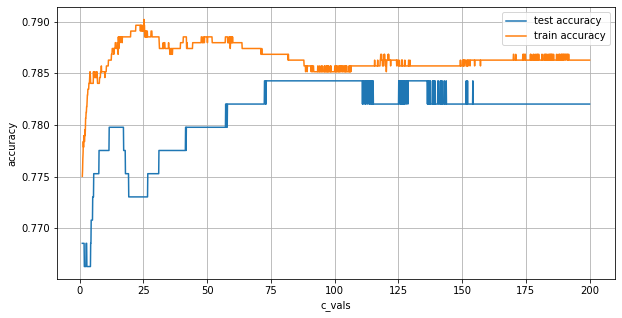

In [18]:
plt.figure(figsize=(10,5))
plt.plot(c_vals, test_accur_over_c, label="test accuracy")
plt.plot(c_vals, train_accur_over_c, label="train accuracy")

plt.xlabel('c_vals')
plt.ylabel('accuracy')

plt.legend()

plt.grid()
plt.show()

In [19]:
m = X_test.shape[0]

test_error_over_m = np.zeros(m)
train_error_over_m = np.zeros(m)

In [21]:
from sklearn.metrics import mean_squared_error

for m_val in range(1, m):
    new_X_train = X_train[:m_val+1]
    new_y_train = y_train[:m_val+1]
    
    new_X_test = X_test[:m_val+1]
    new_y_test = y_test[:m_val+1]
    
    logreg = LogisticRegression(C=best_c_val, solver='liblinear', random_state=0)

    # fit the model
    logreg.fit(new_X_train, new_y_train)
    
    train_error_over_m[m_val] = mean_squared_error(new_y_train, logreg.predict(new_X_train))
    test_error_over_m[m_val] = mean_squared_error(new_y_test, logreg.predict(new_X_test))

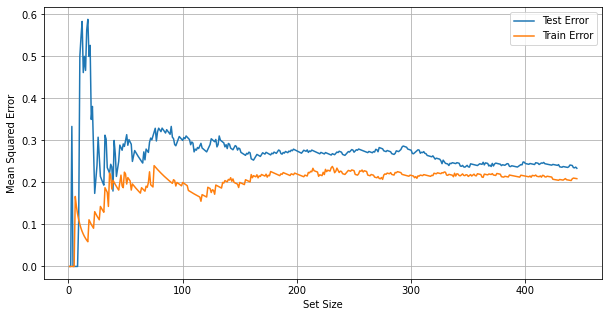

In [22]:
plt.figure(figsize=(10,5))

plt.plot(list(range(1, m + 1)), test_error_over_m, label="Test Error")
plt.plot(list(range(1, m + 1)), train_error_over_m, label="Train Error")

plt.xlabel('Set Size')
plt.ylabel('Mean Squared Error')

plt.legend()

plt.grid()
plt.show()

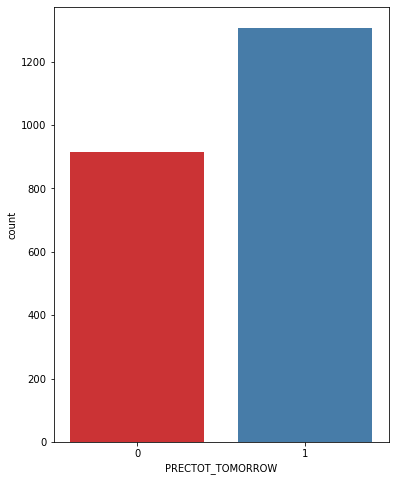

In [11]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="PRECTOT_TOMORROW", data=df, palette="Set1")
plt.show()

In [12]:
correlation = df.iloc[:, 3:].corr()

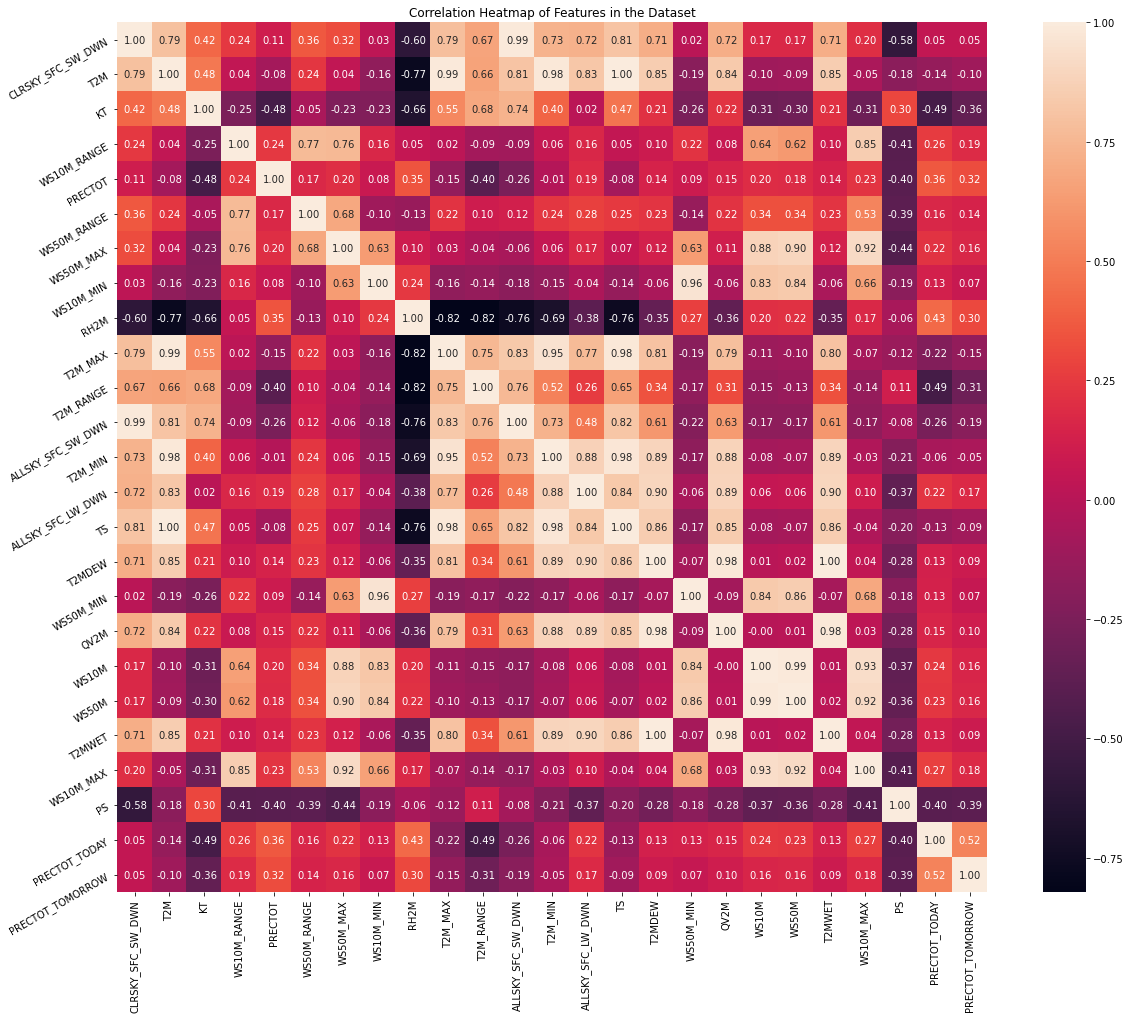

In [13]:
plt.figure(figsize=(20,16))
plt.title('Correlation Heatmap of Features in the Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [19]:
pair_parameters = ['T2M_MIN', 'T2M', 'ALLSKY_SFC_LW_DWN', 'QV2M', 'T2M_MAX', 'WS50M_MAX', 'RH2M', 'WS10M_MIN', 'TS', 
                   'T2MDEW', 'T2M_RANGE', 'WS50M_MIN', 'WS10M_MAX', 'T2MWET', 'ALLSKY_SFC_SW_DWN', 'WS10M', 'PS', 
                   'CLRSKY_SFC_SW_DWN', 'PRECTOT_TOMORROW']

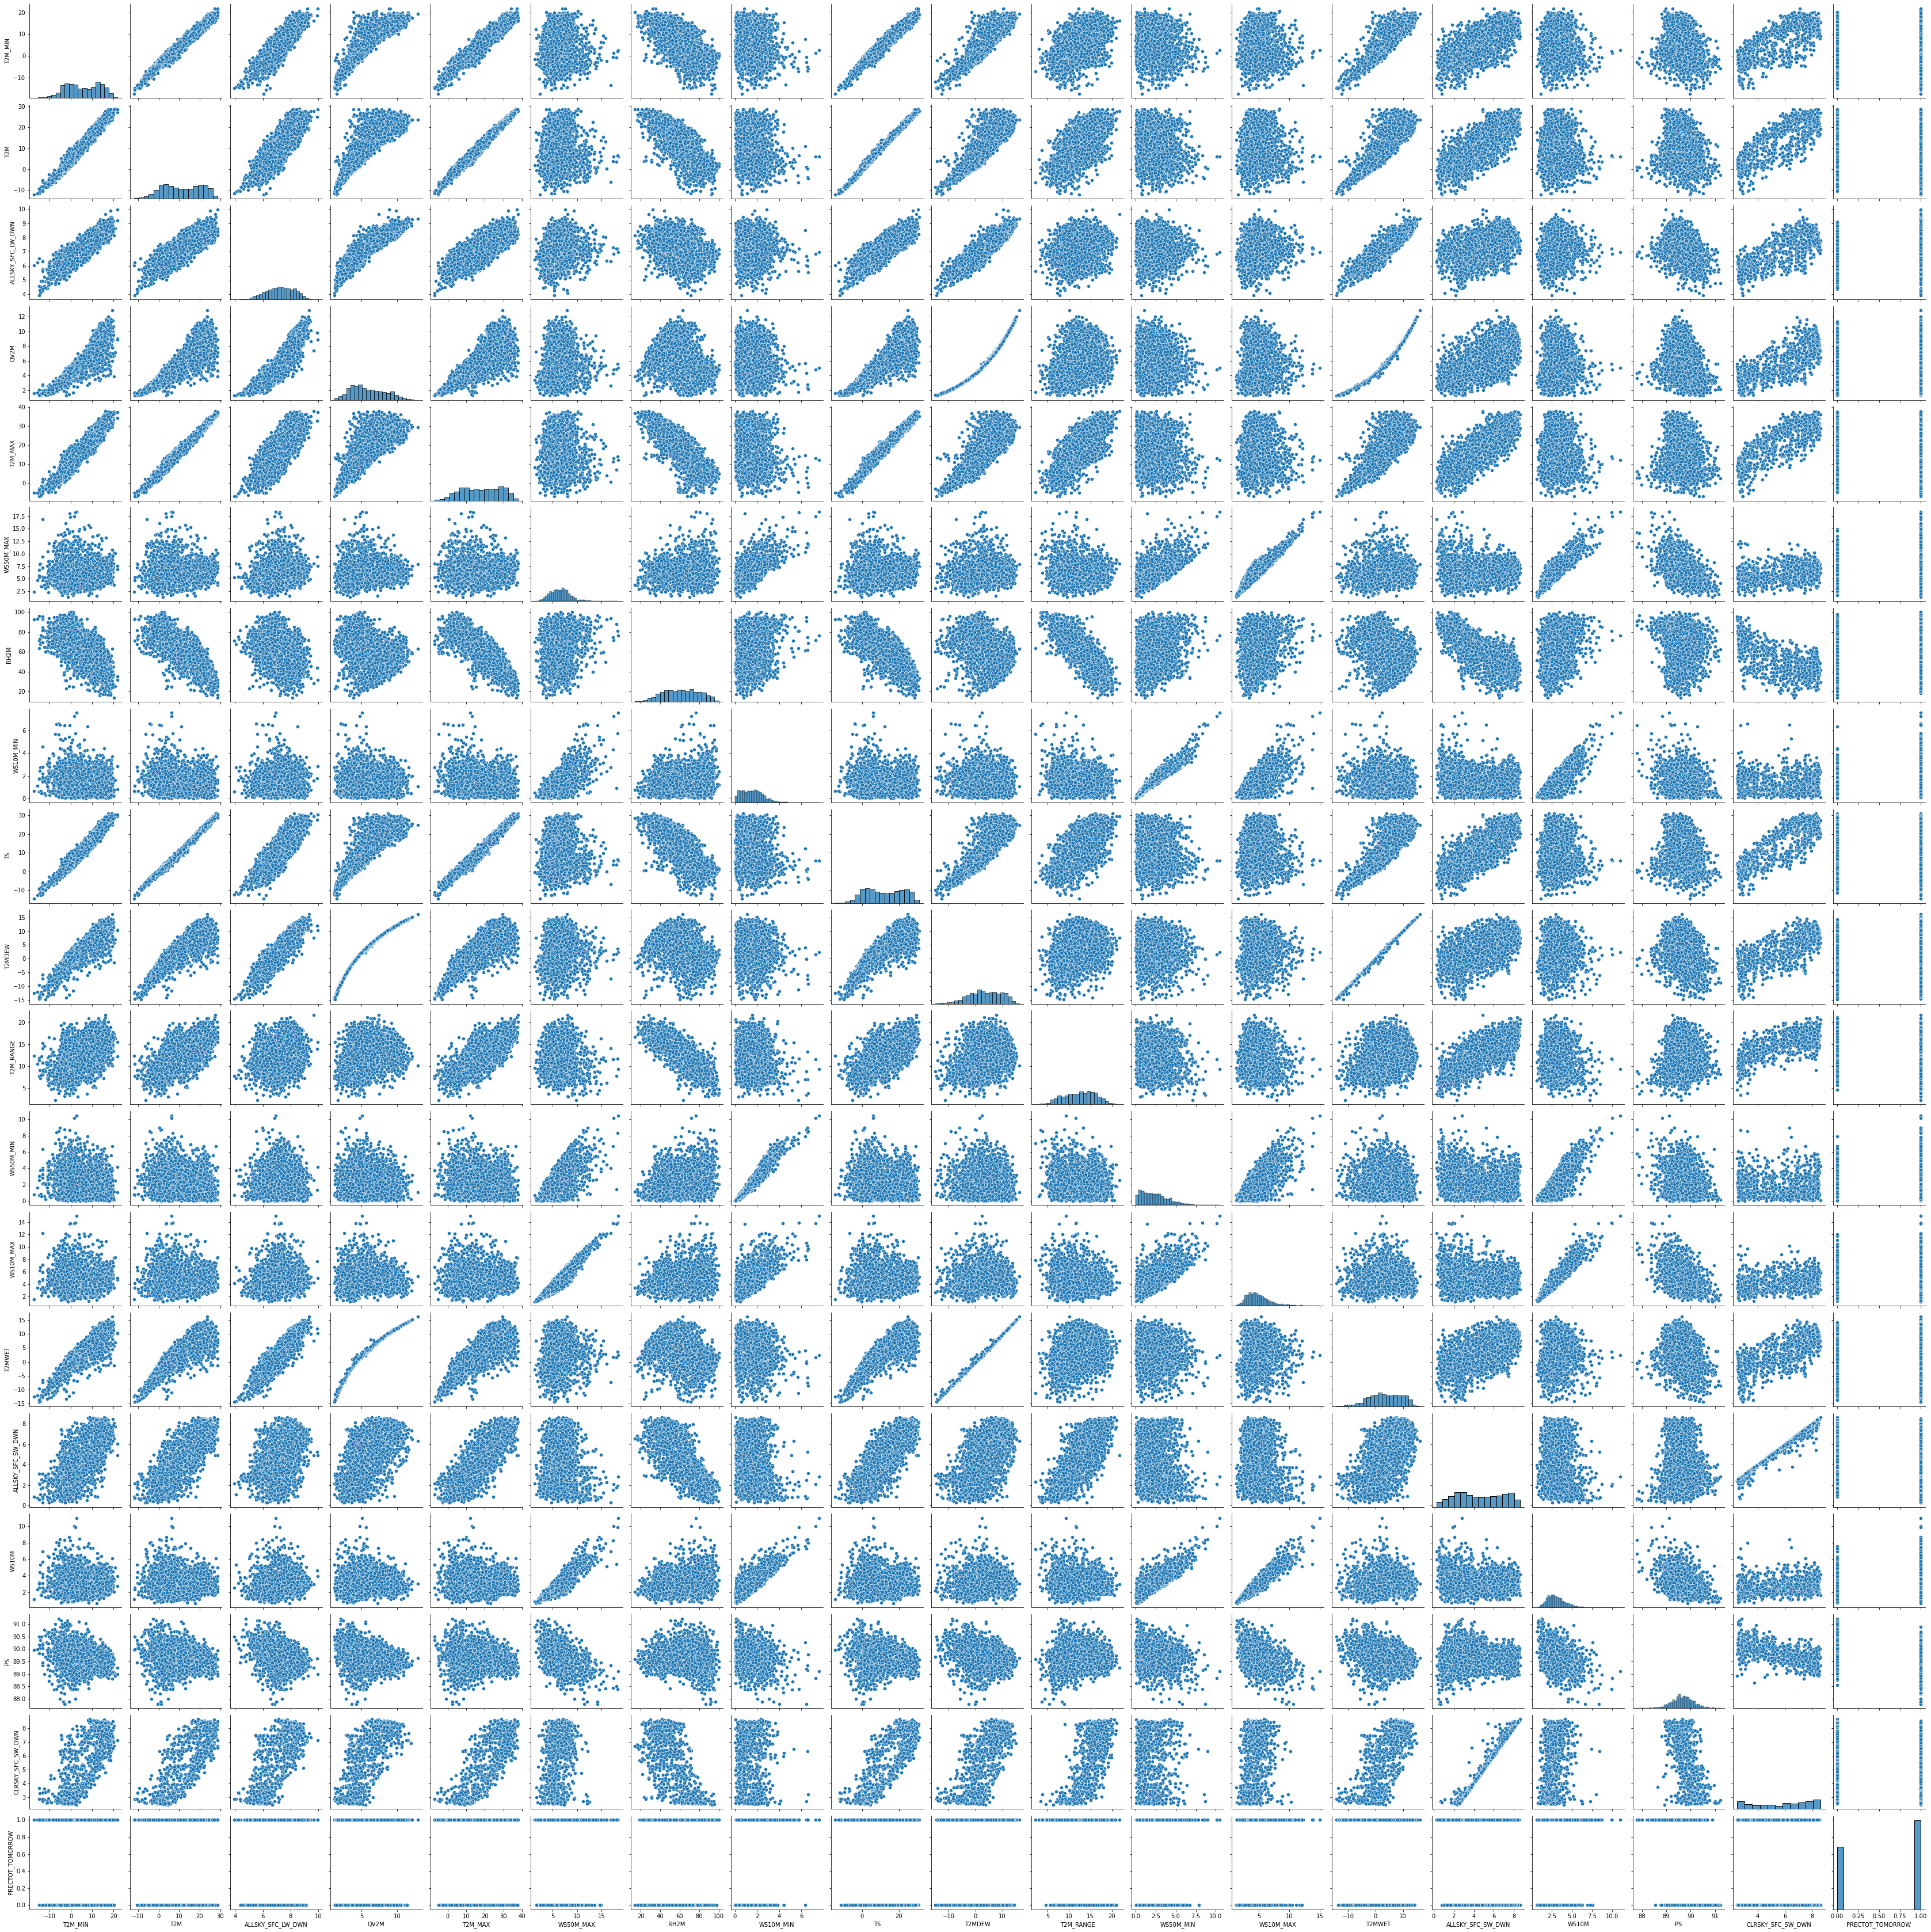

In [20]:
sns.pairplot(df[pair_parameters], kind='scatter', diag_kind='hist', palette='Rainbow')
plt.show()